In [1]:
import os
import copy
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from aml_dl.mdn.model.tf_mdn_model import MixtureDensityNetwork

In [2]:
from __future__ import print_function
import numpy as np
from sklearn.model_selection import train_test_split

def next_batch(x_data, y_data, batch_size):
    num_examples = x_data.shape[0]
    start = 0
    end = start + batch_size

    # Shuffle the data
    perm = np.arange(num_examples)
    np.random.shuffle(perm)
    xx_data = x_data[perm].copy()
    yy_data = y_data[perm].copy()

    return xx_data[start:end], yy_data[start:end]

def build_1d_mdn_toy_dataset(N):
    y_data = np.random.uniform(-10.5, 10.5, N)
    r_data = np.random.normal(size=N)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((N, 1))
    y_data = y_data.reshape((N, 1))
    return train_test_split(x_data, y_data, random_state=42)

def print_all_data(x_train, y_train, x_test, y_test):
    print(" Size of features in training data: {}".format(x_train.shape))
    print(" Size of output in training data: {}".format(y_train.shape))
    print(" Size of features in test data: {}".format(x_test.shape))
    print(" Size of output in test data: {}".format(y_test.shape))

def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """Draws samples from mixture model. Returns 2d array with input X and sample from prediction of mixture model."""
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
    return samples

In [3]:
N = 5000  # number of data points
x_train, x_test, y_train, y_test = build_1d_mdn_toy_dataset(N)
print_all_data(x_train, y_train, x_test, y_test)

 Size of features in training data: (3750, 1)
 Size of output in training data: (3750, 1)
 Size of features in test data: (1250, 1)
 Size of output in test data: (1250, 1)


[   0    2    3 ..., 3747 3748 3749]
(2986, 1)
(2986, 1)


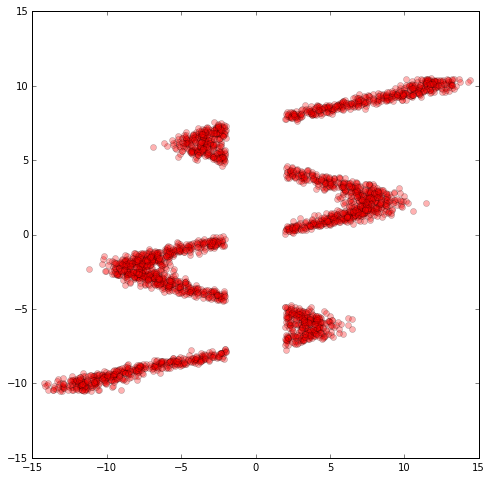

In [4]:
plt.figure(figsize=(8, 8))

indices = np.where( (x_train[:,0] < -2.0) | (x_train[:,0] > 2.0) )
print(indices[0])
x_train = x_train[indices[0],]
y_train = y_train[indices[0],]

print(x_train.shape)
print(y_train.shape)

plt.plot(x_train, y_train,'ro',alpha=0.3)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

In [5]:
EXP_NAME = 'exp_mdn'

aml_data = '~/.aml_data_tmp'
check_point_dir   = aml_data + '/aml_dl/mdn/tf_check_points/exp_mdn/'
summary_dir = aml_data + '/aml_dl/mdn/summaries/exp_mdn/'

if not os.path.exists(check_point_dir):
    os.makedirs(check_point_dir)

if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

adam_params = {
    'type': 'adam',
    'params': {'learning_rate' : 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'use_locking': False}
}

network_params = {
    'dim_input': 1, 
    'dim_output': 1,
    'n_hidden': [15,15],
    'k_mixtures': 10,
    'optimiser': adam_params,
}

In [6]:
tf.set_random_seed(42)
sess = tf.InteractiveSession()

In [7]:
mdn = MixtureDensityNetwork(network_params)
mdn._init_model()

In [8]:
def get_adversarial_examples(data_x, data_y, loss_grad, epsilon=0.0001, no_examples=50):
    dim_input = 1
    dim_output = 1

    rand_indices = np.arange(len(data_x))[:no_examples]#[random.randint(0,len(data_x)-1) for _ in range(no_examples)]
    ##
    x_adv = np.zeros((len(rand_indices), dim_input))
    y_adv = np.zeros((len(rand_indices), dim_output))

    idx = 0
    for index in rand_indices:
        x_adv[idx,:] = data_x[index,:] + epsilon*np.sign(loss_grad[index])
        y_adv[idx,:] = data_y[index]
        idx += 1

    return x_adv, y_adv

In [9]:
sess.run(tf.global_variables_initializer())
iterations = 5000
batch_size = 128
adv_batchsize = 64
adv_epsilon = 0.001

loss = np.zeros(iterations)
            
for i in range(iterations):
    train_op = mdn._ops['train']
    loss_op  = mdn._ops['loss']
    grad_op  = mdn._ops['loss_grad']

    batchsize = batch_size
    batch_indices = np.random.choice(np.arange(len(x_train)), size=batchsize)
    x_batch = x_train[batch_indices]
    y_batch = y_train[batch_indices]
                    
    #compute value of the gradients
    loss_grad = sess.run(grad_op, feed_dict={mdn._ops['x']: x_batch, mdn._ops['y']: y_batch})
            
    #get adversarial examples
    x_adv, y_adv = get_adversarial_examples(data_x=x_batch, 
                                            data_y=y_batch, 
                                            epsilon=adv_epsilon, 
                                            loss_grad=loss_grad, 
                                            no_examples=adv_batchsize)

    x_batch = copy.deepcopy(np.append(x_adv, x_batch, axis=0))
    y_batch = copy.deepcopy(np.append(y_adv, y_batch, axis=0))

    _, loss[i] = sess.run([train_op, loss_op], feed_dict={mdn._ops['x']: x_batch, mdn._ops['y']: y_batch})

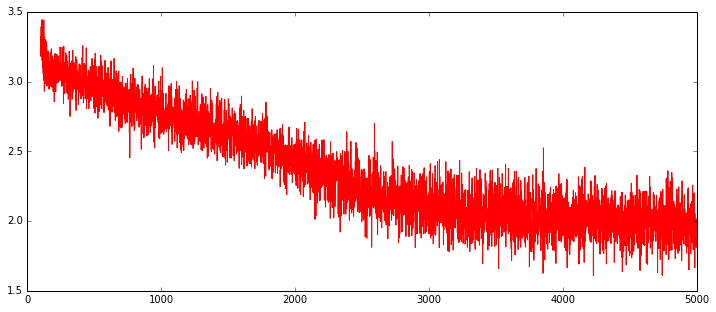

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(100, iterations,1), loss[100:], 'r-')
plt.show()

In [11]:
x_values = np.float32(np.arange(-15.0,15.0, 0.1))
x_test = x_values
print(x_values.shape)

out_mus = mdn.run_op(sess, 'mu', np.expand_dims(x_test,axis=1))
out_sigma = mdn.run_op(sess, 'sigma', np.expand_dims(x_test,axis=1))
out_pis = mdn.run_op(sess, 'pi', np.expand_dims(x_test,axis=1))

(300,)


In [12]:
mean_out = mdn.forward(sess, np.expand_dims(x_test,axis=1))

In [13]:
out_mus = np.array(out_mus)
out_sigma = np.array(out_sigma)
out_pis = np.array(out_pis)
#out_pis = np.array(out_pis)

print(out_mus.shape)
print(out_sigma.shape)
print(out_pis.shape)
#print(mean_out.shape)

(1, 300, 1, 10)
(1, 300, 10)
(1, 300, 10)


In [14]:
def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    mu = 0
    std = 0
    idx = 0

    # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, 0, idx]
            std = out_sigma[i, idx]
            result[i, j] = np.random.normal(mu, std, size=1)
    return result

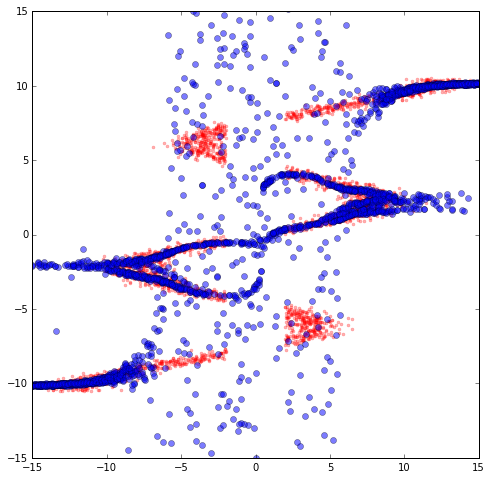

In [15]:
%matplotlib inline

fig = plt.figure(figsize=(8,8))
y_sample = generate_ensemble(out_pis[0], out_mus[0], out_sigma[0])
plt.plot(x_train, y_train,'r.', x_test, y_sample, 'bo', alpha=0.3)
plt.plot(x_test, y_sample, 'bo', alpha=0.3)

# plt.plot(x_test, reshaped_out_mus[0],'-',linewidth=5, alpha=0.3)

plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

In [16]:
from scipy import stats
from matplotlib.transforms import Affine2D

def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
    """Plots the mixture of Normal models to axis=ax comp=True plots all components of mixture model"""
    x = np.linspace(-15, 15, 250)
    final = np.zeros_like(x)
    
    base = plt.gca().transData
    rot = Affine2D().rotate_deg(90)

    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Normal ' + str(i), alpha=0.5)
    ax.plot(x, final, label='Mixture of Normals ' + label, color='b',transform= rot + base)
    #ax.legend(fontsize=12, bbox_to_anchor=(1.5, 1), ncol=2)

def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """Draws samples from mixture model. Returns 2d array with input X and sample from prediction of mixture model."""
    samples = np.zeros((amount, 2))
    n_mix = pred_weights.shape[1]
    
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
    return samples

2.1


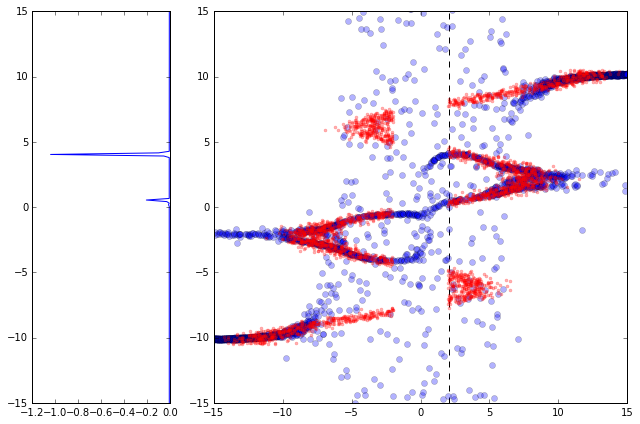

In [17]:
from matplotlib import gridspec

x_test = np.float32(np.arange(-15.0,15.0, 0.01))

out_mus = np.array(mdn.run_op(sess, 'mu', np.expand_dims(x_test,axis=1)))
out_sigma = np.array(mdn.run_op(sess, 'sigma', np.expand_dims(x_test,axis=1)))
out_pis = np.array(mdn.run_op(sess, 'pi', np.expand_dims(x_test,axis=1)))

reshaped_out_mus = np.reshape(out_mus, (out_mus.shape[0], out_mus.shape[1], out_mus.shape[3]))
#print(reshaped_out_mus.shape)

y_sample = sample_from_mixture(x_test, out_pis[0], reshaped_out_mus[0], out_sigma[0], amount=len(x_test))

#plt.subplot(1, 2, 1)
rnd_id = np.random.randint(0, len(x_test))
print(x_test[rnd_id])
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

#ax = fig.add_subplot(1, 2, 1)
ax = plt.subplot(gs[0])
plot_normal_mix(out_pis[0][rnd_id], reshaped_out_mus[0][rnd_id], out_sigma[0][rnd_id], ax, comp=False)
# ax.axvline(x=y_test[rnd_id], color='g', alpha=0.5, lw=2)
# ax.axhline(y=y_test[rnd_id], color='g', alpha=0.5, lw=2)

#ax2 = fig.add_subplot(1, 2, 2)
ax2 = plt.subplot(gs[1])
ax2.plot(y_sample[:, 0], y_sample[:, 1],'bo',alpha=0.3)
plt.plot(x_train, y_train,'r.',alpha=0.3)
ax2.vlines(x=x_test[rnd_id], ymin=-15, ymax=15, color='k', linestyles='dashed')
ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15)

plt.tight_layout()
plt.show()

In [18]:
data_range = np.arange(-15.0, 15.0, 0.1)
x_test = np.float32(data_range)

out_mus = np.array(mdn.run_op(sess, 'mu', np.expand_dims(x_test,axis=1)))
out_sigma = np.array(mdn.run_op(sess, 'sigma', np.expand_dims(x_test,axis=1)))
out_pis = np.array(mdn.run_op(sess, 'pi', np.expand_dims(x_test,axis=1)))

x_heatmap_label = np.float32(x_test)
y_heatmap_label = np.float32(x_test)

import math
def custom_gaussian(x, mu, std):
    oneDivSqrtTwoPI = 1.0 / math.sqrt(2.0*math.pi)
    x_norm = (x-mu)/std
    result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2.0)/std
    return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
    N = x_heatmap_label.size
    M = y_heatmap_label.size
    K = network_params['k_mixtures']
    z = np.zeros((N, M)) # initially random [0, 1]

    mu = 0
    std = 0
    pi = 0    
    # transforms result into random ensembles
    for k in range(0, K):
        for i in range(0, M):
            pi = out_pi[i, k]
            mu = out_mu[i, 0, k]
            std = out_sigma[i, k]
            for j in range(0, N):
                z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)
    return z

def draw_heatmap(xedges, yedges, heatmap):
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap, extent=extent, interpolation='nearest')
    plt.colorbar()
    plt.show()

In [19]:
z = generate_heatmap(out_pis[0], out_mus[0], out_sigma[0], x_heatmap_label, y_heatmap_label)

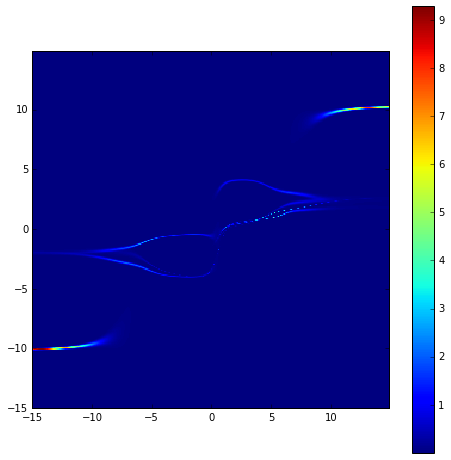

In [20]:
draw_heatmap(x_heatmap_label, y_heatmap_label, z)